# Data Exploration

## Imports

In [ ]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
import cPickle as pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Indexing the files

In [3]:
directory = "data/train/"
d = os.listdir(directory)
filenames = []
for f in d:
    if ".png" not in f:
        continue
    filenames.append(f)

## Displaying a Sample

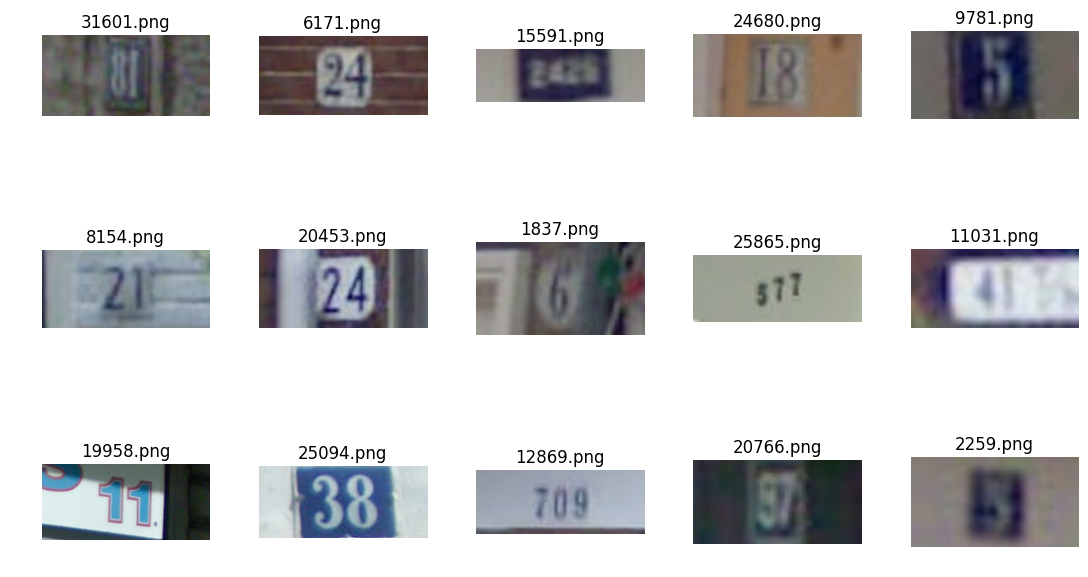

In [4]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 5
for c in np.random.choice(len(filenames), rows * columns):
    img = mpimg.imread(directory + filenames[i])
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.title(filenames[i])
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

## Accessing the Data
The `digitStruct.mat` file included with the SVHN dataset contains the labels of the digits in the dataset images, as well as bounding boxes that describe where in the image these digits occur.

This `.mat` file is an HDF5 file format, which unfortunately I find to be too sparsely documented for me to work with (I will spare you the code boxes in which I floundered around with `<HDF5 object reference>` and other objects I didn't know how to manipulate).

Accordingly, adopting the processing pipeline from [master_yoda](https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/3) as described in the Udacity forums, we transfer the data contained within `digitStruct.mat` into a Python dictionary for easier, more-frequently-documented manipulation.

After this (sort of lengthy) transcription has taken place, we pickle the data in accordance with master_yoda's previously-defined processing pipeline, so that on subsequent loadings of the `jupyter` notebook, we can just load the pickle file.

In [5]:
f = h5py.File(directory + 'digitStruct.mat', 'r')

In [6]:
metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

In [7]:
def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(obj[0][0])
    else:
        for k in range(obj.shape[0]):
            vals.append(f[obj[k][0]][0][0])
    metadata[name].append(vals)

In [8]:
for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)

### Saving the Pickle File

In [15]:
pickle_file = directory + 'train_metadata.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

### Loading the Pickle File

In [4]:
pickle_file = directory + 'train_metadata.pickle'
f = open(pickle_file, 'r')
metadata = pickle.load(f)

In [5]:
l = len(metadata['label'])

In [6]:
metadata['label'][rand.randint(0, l - 1)]

[4.0, 4.0]

## Statistics

### Label Distribution

In [101]:
labels = []
for label_group in metadata['label']:
    for label in label_group:
        labels.append(label)

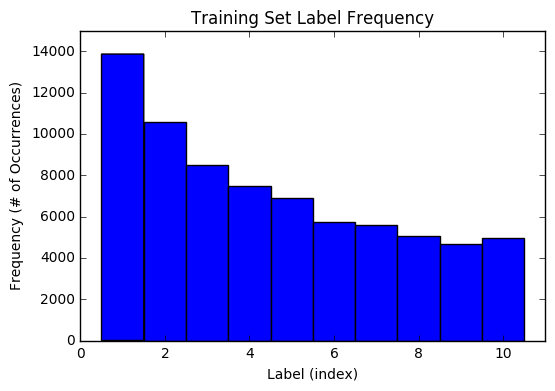

In [119]:
n, bins, patches = plt.hist(labels, bins=range(1,12), align='left')
plt.axis([0,11,0,15000])
plt.title("Training Set Label Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Label (index)")

Recall that the labels the SVHN dataset presents us with are numbers in the inclusive range (1, 10), where the labels 1 through 9 represent the digits 1 through 9, and the label 10 represents the digit 0.

So, what we see is fascinating: The digits are not uniformly distributed.  
We would expect a uniform distribution on rolls of a single die, or on the rank of cards drawn from a deck with replacement.  That is to say, we would expect uniformity if it were equally likely that any enumerated outcome could occur.

What we notice here, however, is that `1` is much more likely to occur in this dataset than is `0`, and that `0` is marginally more likely to occur in this dataset than is `9`, which is the least likely of all.  
Let's try to give more quantitative heft to this via **norming** our histogram:

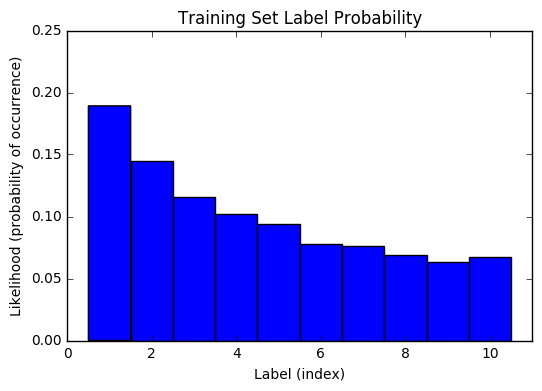

In [122]:
n, bins, patches = plt.hist(labels, bins=range(1,12), normed=True, align='left')
plt.axis([0,11,0,0.25])
plt.title("Training Set Label Probability")
plt.ylabel("Likelihood (probability of occurrence)")
plt.xlabel("Label (index)")

Revisiting our narrative from above, if we were to pick a digit at random from our dataset, there's ~20% chance that digit is a `1`, and a ~7.5% chance that digit is a `9`.

This is important to note, since if we see our model is correctly classify classifying 20% of the data, it could be the case that our model is guessing `1` for every classification.

### Image Cardinality
Just how many digits are we dealing with here anyway?!?!  
That is, what is the distribution of the number of digits per image in the SVHN dataset.

In [9]:
label_count = []
for label_group in metadata['label']:
    label_count.append(len(label_group))

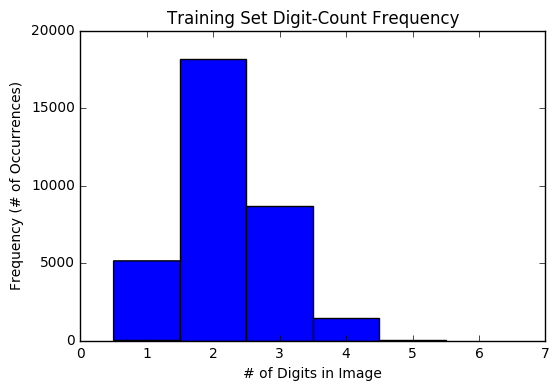

In [126]:
n, bins, patches = plt.hist(label_count, bins = range(1,7), align='left')
plt.axis([0,7,0,20000])
plt.title("Training Set Digit-Count Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("# of Digits in Image")

In [95]:
label_count.count(0), label_count.count(5), label_count.count(6)

(0, 9, 1)

Note that, in the above histogram, there are no images with `0` digits in them, and there is only one image with `6` digits in it.

It is thus perhaps the case that a Tensor which has been built to identify digits in a given image may be pre-disposed to look for two digits, regardless of whether there are 1 or 6 actually in the image.

# Exploratory Visualization

House numbers aren't always straight.  This is (1) because such precision is hard, and (2) because sometimes sloping numbers look better.

Let's explore how the numbers slope in the SVHN dataset

In [104]:
# Our bin from which to plot a degree histogram
avg_degrees = []

# Consider each image
for i in range(len(metadata['left'])):
    
    # Images with only 1 number don't have a defined number slope
    if len(metadata['left'][i]) == 1:
        continue
        
    # Our bin from which to average the angle of the numbers
    # This assumes that people _tried_ to put their house numbers on straight
    degreeses = []
    
    # for each coordinate index except the last:
    for j in range(len(metadata['left'][i]) - 1):
        
        # Handle zero-division
        if metadata['left'][i][j]-metadata['left'][i][j+1] == 0:
            # It's assumed that all vertical house numbers descend
            degreeses.append(-90)
        else:
            # Convert slope to degrees, keeping in mind that slope calculation degrades Quadrant information
            tmpDegrees = math.atan((metadata['top'][i][j+1]-metadata['top'][i][j])/(metadata['left'][i][j+1]-metadata['left'][i][j]))*180/math.pi
            
            # Add Quadrant information back in
            # i.e. whether a positive line points to Q1 or to Q3, or
            # whether a negative line points to Q4 or Q2
            diff = metadata['top'][i][j+1] - metadata['top'][i][j]
            
            # A line is positive because it points to Q3
            if diff < 0 and tmpDegrees > 0:
                tmpDegrees -= 180
            
            # A line is negative because it points to Q2
            if diff > 0 and tmpDegrees < 0:
                tmpDegrees += 180
            
            degreeses.append(tmpDegrees)
    
    # Store the average slope for the digits in this image
    avg_degrees.append(np.mean(degreeses))

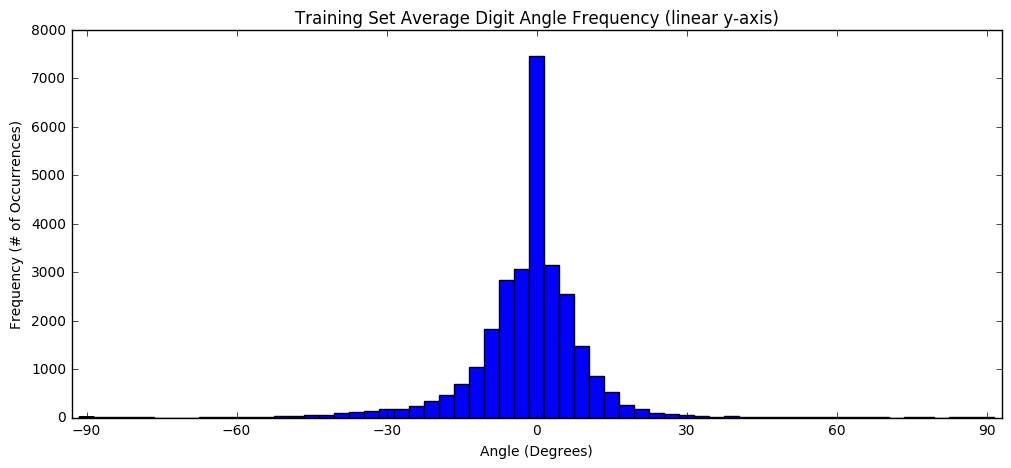

In [138]:
plt.figure(figsize=(12,5))
n, bins, patches = plt.hist(avg_degrees, bins=np.arange(-91.5,93,3), align='mid')
plt.axis([-93,93,0,8000])
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.title("Training Set Average Digit Angle Frequency (linear y-axis)")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Angle (Degrees)")

In [142]:
def gt_degrees(d):
    gt = 0
    for i in avg_degrees:
        if i > d:
            gt += 1
    return gt

def lt_degrees(d):
    lt = 0
    for i in avg_degrees:
        if i < d:
            lt += 1
    return lt

def bt_degrees(l, h):
    bt = 0
    for i in avg_degrees:
        if l < i < h:
            bt += 1
    return bt

In [144]:
gt_degrees(30), gt_degrees(60), gt_degrees(75), gt_degrees(90)

(165, 16, 9, 2)

In [145]:
bt_degrees(90, 93), bt_degrees(173,175)

(1, 1)

In [146]:
lt_degrees(-30), lt_degrees(-60), lt_degrees(-75), lt_degrees(-90), 

(685, 33, 25, 0)

In [147]:
bt_degrees(-91.5, -88.5)

12

Interestingly, as can be seen above, there are 9 images in which the slope of the numbers suggests a bottom-to-top ordering.  This almost certainly wasn't intentional.

Is this an error in the dataset?  If so, it affects only a few of the images.

Note also that there aren't any images in which the house numbers are angled beyond -90 degrees.  This suggests that no one placed numbers close enough to bottom-to-top orientation for the error inherent in placing numbers to cause that particular placement to exceed -90 degrees.  Neat!

Let's view the same plot, but with a logarithmically-scaled y-axis, to better see the above-identified outliers.

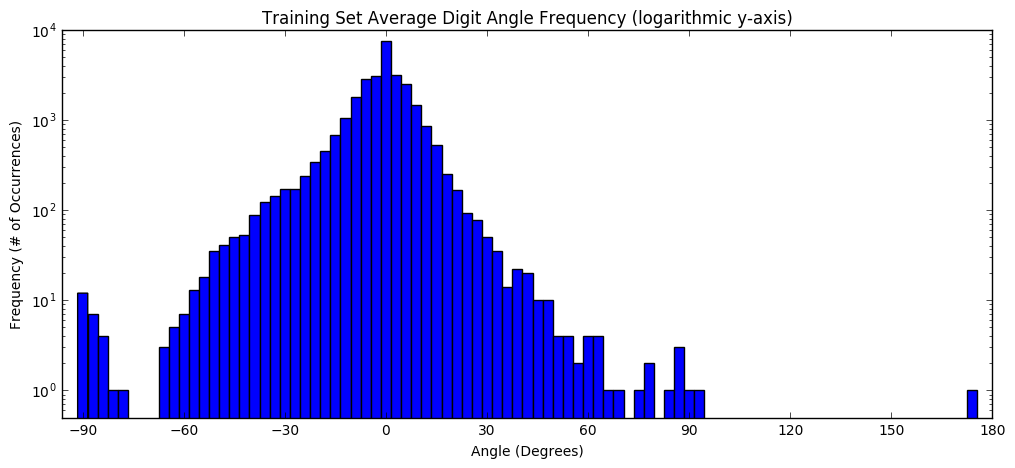

In [148]:
plt.figure(1, figsize=(12,5))
plt.yscale('log')
plt.ylim(0.5, 10000)
plt.xlim(-96, 180)
n, bins, patches = plt.hist(avg_degrees, bins=np.arange(-91.5, 180, 3), align='mid')
plt.xticks([-90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.title("Training Set Average Digit Angle Frequency (logarithmic y-axis)")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Angle (Degrees)")

As we can see in the above histograms, house numbers are predominately flattish, but some slope upwards (have a positive `Angle`), and some slope downwards (have a negative `Angle`).

As expected, the tail on the negative side is fatter than on the positive side, meaning that more house numbers slope downwards than slope upwards.

This makes sense, as bottom-to-top ordering is not the reading convention anywhere.
![Writing Directions of the World](images/Writing_directions_of_the_world.svg)
(image [source](https://en.wikipedia.org/wiki/Writing_system#/media/File:Writing_directions_of_the_world.svg))  

### Relevance to Analysis
This suggests that the house numbers are, by overwhelming majority, ordered left-to-right.  Thus, after having identified digits in the SVHN images, digits can be ordered in the output based off of their `x-coordinate`, or `metadata['left']` value as referred to above.

# Algorithms and Techniques
## Image Preprocessing
The images in the SVHN dataset are many different sizes:
```
$ file *.png
...
28668.png:             PNG image data, 153 x 73, 8-bit/color RGB, non-interlaced
28669.png:             PNG image data, 67 x 34, 8-bit/color RGB, non-interlaced
2866.png:              PNG image data, 44 x 21, 8-bit/color RGB, non-interlaced
28670.png:             PNG image data, 100 x 50, 8-bit/color RGB, non-interlaced
28671.png:             PNG image data, 83 x 34, 8-bit/color RGB, non-interlaced
28672.png:             PNG image data, 108 x 49, 8-bit/color RGB, non-interlaced
...
```
Unfortunately, our neural net will need its input to be consistently-sized.  
That is to say, we need to pick *a* size to which we resize all images, before we feed them to the neural net.

Images which are larger than the destination size are going to *lose* some information, while images which are the destination size or smaller aren't going to gain information.  
Accordingly, we want to pick a size where information loss isn't significant.

A note here:  
Just because we downsize the image doesn't mean that there is significant information loss.  
A 3200x4800 image of the letter `A` is probably still faithfully represented if downsized to 32x48, or smaller.

Let's get an idea of the input dimensions:

In [ ]:
img_width, img_height = [], []

for f in filenames:
    with Image.open(directory + f) as im:
        w, h = im.size
        
        img_width.append(w)
        img_height.append(h)

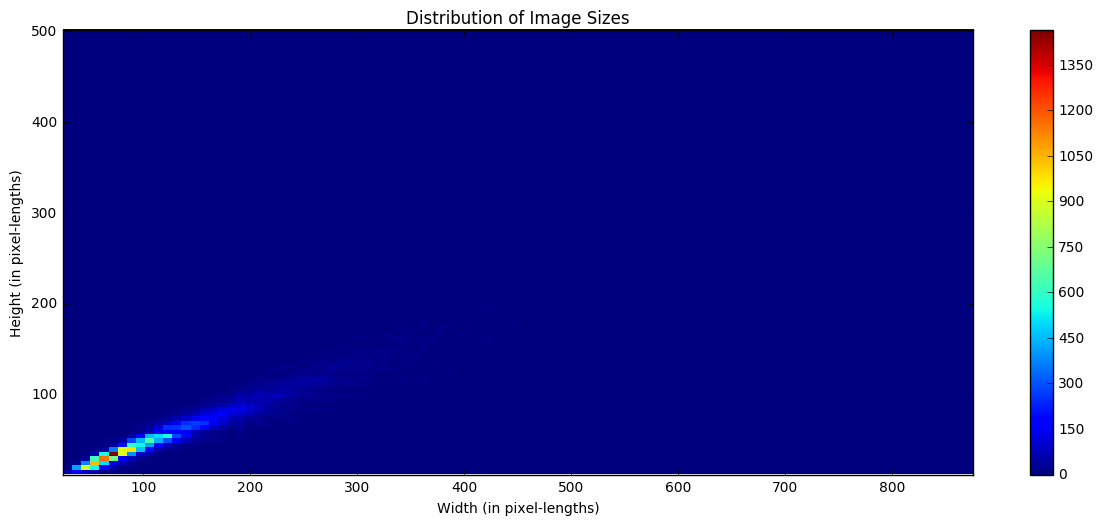

In [72]:
plt.figure(1, figsize=(12,5))
plt.hist2d(img_width, img_height, bins=100)
plt.tight_layout()
plt.colorbar()
plt.title("Distribution of Image Sizes")
plt.xlabel("Width (in pixel-lengths)")
plt.ylabel("Height (in pixel-lengths)")
plt.show()

Notice that the above plot suggests that the vast majority of the images are less than 50-or-so pixels tall, and many of them are less than 100 pixels wide.

That is, we can probably downsize these images to 64 x 64 and (hopefully) not lose a lot of information.

In [14]:
img_pixels = []
for i in range(len(img_width)):
    img_pixels.append(img_width[i] * img_height[i])

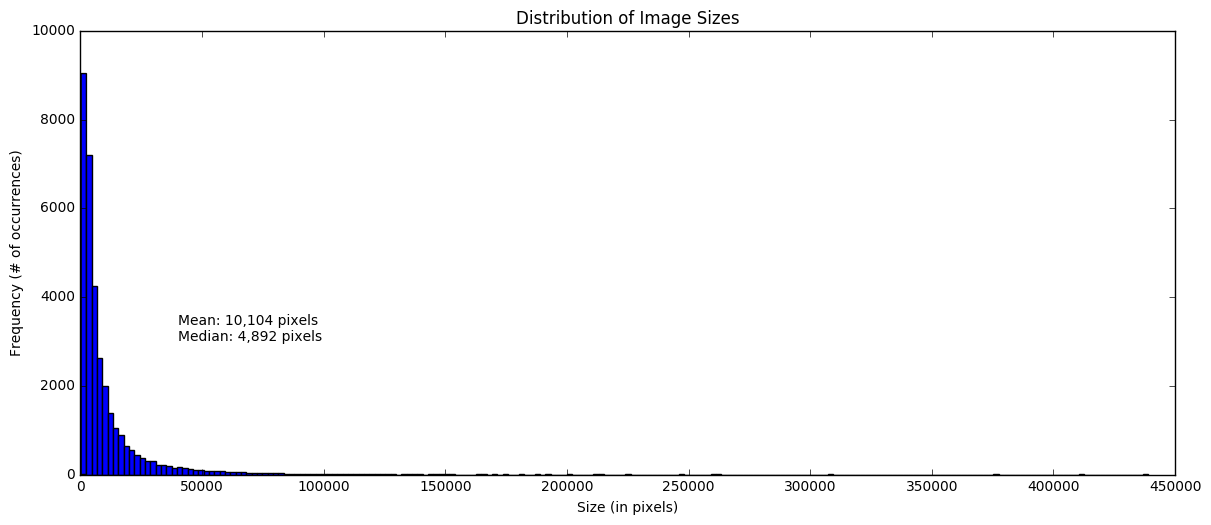

In [81]:
plt.figure(1, figsize=(12,5))
plt.hist(img_pixels, bins=200)
plt.tight_layout()
txt = "Mean: {:,.0f} pixels".format(np.mean(img_pixels))
txt += "\nMedian: {:,.0f} pixels".format(np.median(img_pixels))
plt.text(40000, 3000, txt)
plt.title("Distribution of Image Sizes")
plt.xlabel("Size (in pixels)")
plt.ylabel("Frequency (# of occurrences)")
plt.show()

Let's arbitrarily go with 128x128, the size used by Goodfellow et al.  
But hold on, we can't just rescale our input images, or we'd get too-squished input like this:

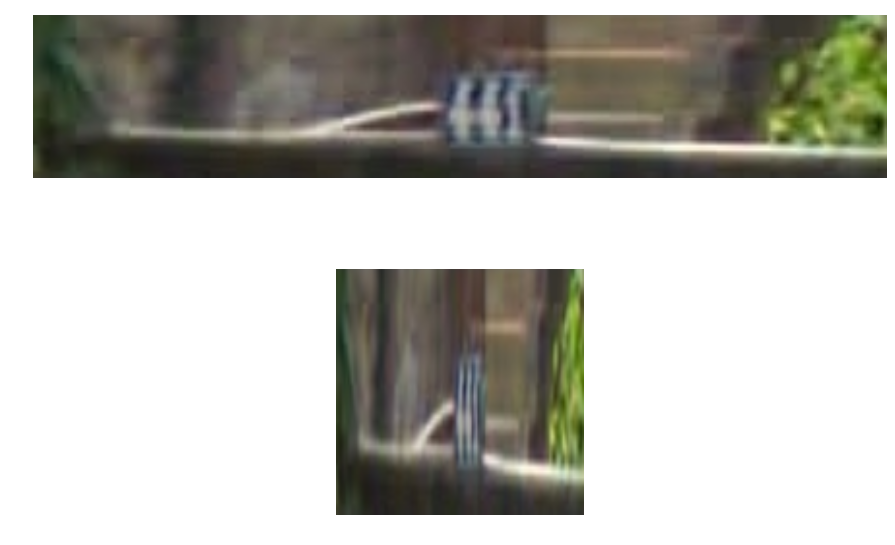

In [114]:
fig = plt.figure(figsize=(11, 7))
with open(directory + filenames[206]) as f:
    fig.add_subplot(211)
    plt.axis("off")
    img = mpimg.imread(f)
    plt.imshow(img)
    
    fig.add_subplot(212)
    plt.axis("off")
    img = misc.imresize(img, (128,128))
    plt.imshow(img)
    plt.show()

We need to be more clever about how we downsize.
## Clever Image Preprocessing
[Goodfellow et al.](https://arxiv.org/pdf/1312.6082v4.pdf) describe the following steps to their image preprocessing:
1. **Find the rectangular bounding box** that will contain individual character bounding boxes.  
   Note that this means finding `y_min`, `y_max`, `x_min`, and `x_max` such that, for each image, no bounding box is clipped.  
   Note further that, for each individual character bounding box, `x_min` is simply `metadata['left'][i]`, and `y_max` is `metadata['top'][i]`.  
   Then, `y_min` can be found by subtracting `metadata['height'][i]` from `y_max`, and `x_max` can be found by adding `metadata['width'][i]` to `x_min`.  
   Then, we simply take the lowest of the `x_min` and `y_min`, and the largest of the `x_max` and `y_max`.

2. **Expand the rectangular bounding box** by 30% in the `x` and `y` directions.  
   This seems like they are intending to increase from the rectangle's centroid, so that if we have a `width` of 20, then `x_min` decreases by 3, and `x_max` increases by 3.
   Note also that this preprocessing step will have to take into account situations where the bounding box expands beyond the border of the images.  
   Since we are later subtracting the mean of each image, perhaps any pixel beyond the boundary of the input image is assigned a value of 127, since 255 would certainly increase the mean, and 0 would certainly decrease the mean.
   
3.  **Crop the image** to this bounding box.

4.  **Resize the image** to 64 x 64.  
   This step can make use of the pipeline we defined earlier, now that we have a better idea, for each image, where the pixels containing the digit information are located.
   
5.  **Crop several 54 x 54 images** from random locations within the 64 x 64 image.
   This step increases the size of the dataset, which is good for training purposes.
   Note that this step **may** cause us to lose some digit information:  
   For each image, we've defined a **rectangle** which bounds all digit boxes.  Therefore the digits are probably in that rectangle.
   Then, we upsized the box by 30%, which is a 15% increase on each axis, on each side.
   Then we resize, which decreases resolution, but doesn't change the relative location of boundaries.
   *Then*, we crop from to 54 pixels from 64 pixels.  We would have to multiply 54 by 18.52% to get back to 64, so if the pixels were all cropped from one side, then we end up with an image which is **inside** of the original digit-containing rectangle.
   This is probably not a huge deal, but it's worth noting.
   
6. **Subtract the mean** of each image

Let's implement this preprocessing pipeline:

In [ ]:
with open(directory + filenames[16751]) as f:
    plt.axis("off")
    img = mpimg.imread(f)
    plt.imshow(img)

In [39]:
metadata['label'][16752]

[2.0, 3.0, 10.0]

## The Neural Net
We will be building a neural net to output the digits from input images.  The architecture will try to follow, as closely as possible, that architecture described by Goodfellow et al., below:
![Goodfellow et al. Neural Net Architecture](images/architecture.png)  
In short, the above architecture describes a neural net feature extractor which is then used to make 6 predictions: 

In [6]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model

In [ ]:
x = Input((img_channels, img_rows, img_cols))

y = Convolution2D(32, 3, 3, activation="relu", border_mode="same")(x)
y = Convolution2D(32, 3, 3, activation="relu")(y)
y = MaxPooling2D((2, 2))(y)
y = Dropout(0.25)(y)

y = Convolution2D(64, 3, 3, border_mode="same", activation="relu")(y)
y = Convolution2D(64, 3, 3, activation="relu")(y)
y = MaxPooling2D((2, 2))(y)
y = Dropout(0.25)(y)


y = Flatten()(y)
y = Dense(1024, activation="relu")(y)

length = Dense(4, activation="softmax")(y)
digit1 = Dense(10, activation="softmax")(y)
digit2 = Dense(10, activation="softmax")(y)
digit3 = Dense(10, activation="softmax")(y)

model = Model(input=x, output=[length, digit1, digit2, digit3])